In [43]:
import pandas as pd
import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

# disable chained assignments
pd.options.mode.chained_assignment = None 

In [58]:
# Load our data
df = pd.read_excel('jobs.xlsx')

In [59]:
# Clean data

In [60]:
# Clean up column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('#', 'number')

In [61]:
# What are our datatypes?
df.dtypes

job_number                     int64
job_type                      object
job_campaign                  object
campaign_category             object
business_unit                 object
invoice_number                 int64
jobs_total                   float64
completion_date       datetime64[ns]
job_class                     object
summary                       object
customer_id                    int64
customer_name                 object
primary_technician            object
dtype: object

In [62]:
# What is the shape of our data?
df.shape

(16253, 13)

In [63]:
# Any null vales?
df.isnull().values.any()

True

In [64]:
# How many?
df.isnull().sum()

job_number                0
job_type                  0
job_campaign              0
campaign_category     16243
business_unit             0
invoice_number            0
jobs_total                0
completion_date           0
job_class             12431
summary               12324
customer_id               0
customer_name             0
primary_technician       64
dtype: int64

In [65]:
# For this RFM analysis the columns that are showing null values are not usefull
# We DO NOT want to drop the entire column

In [66]:
# Convert completion dates to pd date time
df['completion_date'] = pd.to_datetime(df.completion_date)

# index DF with 'wo_entrydate' AND sort ascending
df = df.sort_values(by='completion_date', ascending=True)
df = df.set_index(df['completion_date'])

In [67]:
# Create date variables 
today = datetime.date.today()
last_monday = today - datetime.timedelta(days=today.weekday())
coming_sat = last_monday + datetime.timedelta(days=-today.weekday(), weeks=1.2)
beg_year = date(date.today().year, 1, 1)
current_year = datetime.datetime.now().year

In [68]:
## Create main DF, and only what we need
rfm = df[['completion_date', 'customer_id', 'job_number', 'jobs_total']]
rfm.head(1)

,completion_date,customer_id,job_number,jobs_total
completion_date,,,,
2018-06-01,2018-06-01,9931896,50064,49.0


In [95]:
# Recency in RFM DF
rfm['recency'] = pd.to_datetime(today) - pd.to_datetime(rfm.completion_date)
rfm.head(1)

,completion_date,customer_id,job_number,jobs_total,recency
completion_date,,,,,
2018-06-01,2018-06-01,9931896,50064,49.0,1208 days


In [70]:
## Create Recency DF using min, when were we there last?
rfm_r = rfm.groupby(['customer_id']).recency.min().reset_index()

In [73]:
## Create Frequency DF, how many work orders were created 
rfm_f = rfm.groupby('customer_id').job_number.count().reset_index()

In [76]:
## How much money has this customer spent with us? 
rfm_m = rfm.groupby('customer_id').jobs_total.sum().reset_index()

In [78]:
## Merge DFs and created RFMF
rfmf = rfm_r.merge(rfm_f, on = 'customer_id', how = 'outer').merge(rfm_m, on = 'customer_id', how = 'outer')
rfmf.head()

,customer_id,recency,job_number,jobs_total
0,9931872,165 days,2,384.4
1,9931873,34 days,26,4232.5
2,9931874,532 days,2,551.4
3,9931875,112 days,4,197.0
4,9931876,133 days,4,517.8


In [79]:
# Update column names
rfmf.columns = ['customer_id', 'recency', 'frequency', 'monetary']

In [81]:
# Create percentile, slicing dfs into 4ths, then giving each customer a score
rfmf['r_percentile'] = rfmf['recency'].rank(method='first', pct=True,ascending=False)
rfmf['r_score'] = pd.qcut(rfmf['r_percentile'], 4, labels=range(4,0,-1))
rfmf['f_percentile'] = rfmf['frequency'].rank(method='first', pct=True,ascending=True)
rfmf['f_score'] = pd.qcut(rfmf['f_percentile'], 4, labels=range(4,0,-1))
rfmf['m_percentile'] = rfmf['monetary'].rank(method='first', pct=True,ascending=True)
rfmf['m_score'] = pd.qcut(rfmf['m_percentile'], 4, labels=range(4,0,-1))

rfmf.head()

,customer_id,recency,frequency,monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score
0,9931872,165 days,2,384.4,0.571186,2,0.482776,3,0.509927,2
1,9931873,34 days,26,4232.5,0.947395,1,0.999830,1,0.978619,1
2,9931874,532 days,2,551.4,0.321568,3,0.482946,3,0.603767,2
3,9931875,112 days,4,197.0,0.730528,2,0.738334,2,0.365009,3
4,9931876,133 days,4,517.8,0.661632,2,0.738503,2,0.586119,2


In [82]:
# Drop unneeded columns
columns1 = ['r_percentile', 'f_percentile', 'm_percentile']
rfmf.drop(columns1, inplace=True, axis=1)

In [84]:
# Concat scores to create score and score total
rfmf['rfm_score'] = rfmf['r_score'].astype(str) + rfmf['f_score'].astype(str) + rfmf['m_score'].astype(str)
rfmf['rfm_score_total'] = rfmf['r_score'].astype(int) + rfmf['f_score'].astype(int) + rfmf['m_score'].astype(int)

rfmf.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,rfm_score_total
0,9931872,165 days,2,384.4,2,3,2,232,7
1,9931873,34 days,26,4232.5,1,1,1,111,3
2,9931874,532 days,2,551.4,3,3,2,332,8
3,9931875,112 days,4,197.0,2,2,3,223,7
4,9931876,133 days,4,517.8,2,2,2,222,6


In [87]:
# Drop unnneeded columns
columns2 = ['r_score', 'f_score', 'm_score']
rfmf.drop(columns2, inplace=True, axis=1)

In [88]:
# Define rfm_level function
def rfm_level(df):
    if df['rfm_score_total'] == 3:
        return 'Champions'
    elif ((df['rfm_score_total'] >= 4) and (df['rfm_score_total'] < 5)):
        return 'Good'
    elif ((df['rfm_score_total'] >= 5) and (df['rfm_score_total'] <= 8)):
        return 'Potential'
    elif ((df['rfm_score_total'] >= 9) ):
        return 'Needs Attention'

In [90]:
# Create a new variable RFM_Level
rfmf['RFM_Level'] = rfmf.apply(rfm_level, axis=1)
rfmf.head()

,customer_id,recency,frequency,monetary,rfm_score,rfm_score_total,RFM_Level
0,9931872,165 days,2,384.4,232,7,Potential
1,9931873,34 days,26,4232.5,111,3,Champions
2,9931874,532 days,2,551.4,332,8,Potential
3,9931875,112 days,4,197.0,223,7,Potential
4,9931876,133 days,4,517.8,222,6,Potential


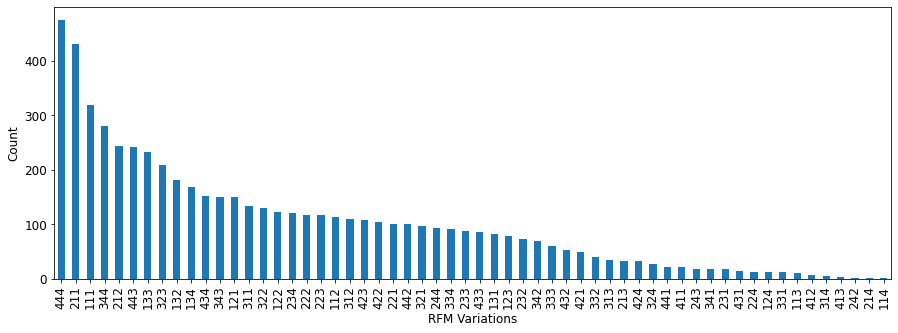

In [91]:
# Plot each possible combination in groups
ax = rfmf['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Variations", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

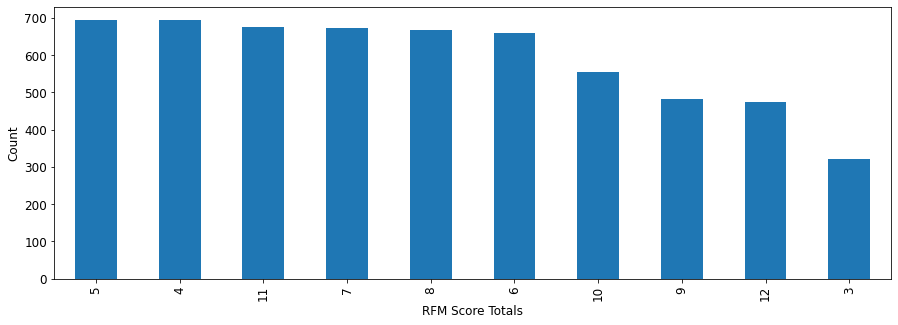

In [93]:
# Plot rfm score totals in groups
ax = rfmf['rfm_score_total'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score Totals", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

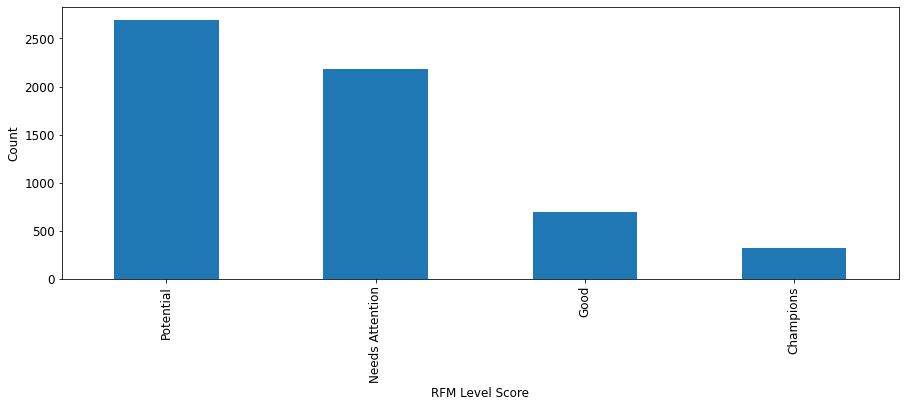

In [94]:
## Plot final groups
ax = rfmf['RFM_Level'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Level Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()